In [ ]:
!pip install jax
!pip install optax

In [ ]:
!pip install dm-haiku

In [ ]:
pip install git+git://github.com/deepmind/jraph.git

  Cloning git://github.com/deepmind/jraph.git to /tmp/pip-req-build-ohgi8k24
  Running command git clone -q git://github.com/deepmind/jraph.git /tmp/pip-req-build-ohgi8k24
  Created wheel for jraph: filename=jraph-0.0.1.dev0-cp36-none-any.whl size=70433 sha256=107566dd53a83513aff1ca43959cc60b7efb5a90a8cc72c0d6b9bf1874161df2
  Stored in directory: /tmp/pip-ephem-wheel-cache-9lb51sh8/wheels/75/f4/9d/7b4424733658d92188650d6341347db20b8a256887b0961a30
Successfully built jraph


In [ ]:
import logging

from absl import app
import haiku as hk
import jax
import jax.numpy as jnp
import jraph
import optax

import numpy as np
import time
import matplotlib.pyplot as plt


def get_zacharys_karate_club() -> jraph.GraphsTuple:
  """Returns GraphsTuple representing Zachary's karate club."""
  social_graph = [
      (1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
      (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
      (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
      (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
      (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
      (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
      (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
      (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
      (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
      (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
      (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
      (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
      (33, 31), (33, 32)]
  # Add reverse edges.
  social_graph += [(edge[1], edge[0]) for edge in social_graph]
  #156 edges au total
  n_club_members = 34

  return jraph.GraphsTuple(
      n_node=jnp.asarray([n_club_members]),
      n_edge=jnp.asarray([len(social_graph)]),
      # One-hot encoding for nodes.
      #matrice d(1,..,1)
      nodes=jnp.eye(n_club_members),
      # No edge features.
      edges=None,
      globals=None,
      senders=jnp.asarray([edge[0] for edge in social_graph]),
      receivers=jnp.asarray([edge[1] for edge in social_graph]))



Les individus représentés pas leur id (allant donc de 0 à 33) sont considérés comme étant les noeuds d'un graphe. Les liens entre ces individus sont matérialisés par les edges de ce graphe. 

Les id des individus sont codés via one hot encoding.
Les edges sont stockés dans la liste social_graph et codés de la manière suivante: chaque élément de social graph correspond à un edge et est représenté sous forme d'un couple (id1, id2) où id1 est l'id de l'individu "émetteur" du edge et id2 est l'id de l'individu "récepteur" du edge. En réalité, la modélisation du réseau n'inclut pas de lien dirigé entre les membre du club. C'est pourquoi pour tout edge (id1,id2), on retrouve dans social_graph (id2,id1). Ainsi, pour modéliser le fait que les edges sont non dirigés, les individus et donc leur noeud associés sont à la fois "emetteur" et "récepteur" d'un edge.

Le graphe est codé par un objet de classe GraphTuple du module jraph (https://github.com/deepmind/jraph/blob/master/jraph/_src/graph.py).

L'objet GraphTuple stocke plusieurs objets de type DeviceArray qui représentent respectivement les individus dans un tableau (one hot encoding).

On stocke également les indices (=numéro des noeuds="id de l'individu") des noeuds étant les récepteurs d'un edge en parcourant la liste des edges.

Idem pour les indices des "senders"

Pour chaque noeud du graphe (chaque noeud correspondant à un individu), on associe la valeur 0 ou 1 selon que l'individu est parti avec Mr Hi ou pas (cela correspond au label de chaque individu qu'on va chercher à prédire). Ces labels sont stockés dans la liste renvoyée par la fonction get_ground_truth_assignments_for_zacharys_karate_club().

(# The only two assignments we know a-priori are those of Mr. Hi (Node 0) and John A (Node 33).)

In [ ]:
get_zacharys_karate_club()

GraphsTuple(nodes=DeviceArray([[1., 0., 0., ..., 0., 0., 0.],
             [0., 1., 0., ..., 0., 0., 0.],
             [0., 0., 1., ..., 0., 0., 0.],
             ...,
             [0., 0., 0., ..., 1., 0., 0.],
             [0., 0., 0., ..., 0., 1., 0.],
             [0., 0., 0., ..., 0., 0., 1.]], dtype=float32), edges=None, receivers=DeviceArray([ 0,  0,  1,  0,  1,  2,  0,  0,  0,  4,  5,  0,  1,  2,  3,
              0,  2,  2,  0,  4,  5,  0,  0,  3,  0,  1,  2,  3,  5,  6,
              0,  1,  0,  1,  0,  1, 23, 24,  2, 23, 24,  2, 23, 26,  1,
              8,  0, 24, 25, 28,  2,  8, 14, 15, 18, 20, 22, 23, 29, 30,
             31,  8,  9, 13, 14, 15, 18, 19, 20, 22, 23, 26, 27, 28, 29,
             30, 31, 32,  1,  2,  2,  3,  3,  3,  4,  5,  6,  6,  6,  7,
              7,  7,  7,  8,  8,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
             13, 16, 16, 17, 17, 19, 19, 21, 21, 25, 25, 27, 27, 27, 28,
             29, 29, 30, 30, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32,
    

In [ ]:
def get_ground_truth_assignments_for_zacharys_karate_club() -> jnp.ndarray:
  """Returns ground truth assignments for Zachary's karate club."""
  return jnp.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
                    0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
def network_definition(graph: jraph.GraphsTuple) -> jraph.ArrayTree:
  """Defines a graph neural network.
  Args:
    graph: GraphsTuple the network processes.
  Returns:
    processed nodes.
  """
  gn = jraph.GraphConvolution(
      update_node_fn=lambda n: jax.nn.relu(hk.Linear(5)(n)),
      add_self_edges=True)
  graph = gn(graph)

  gn = jraph.GraphConvolution(
      update_node_fn=hk.Linear(2))
  graph = gn(graph)
  return graph.nodes


Doc GraphConvolution : https://github.com/deepmind/jraph/blob/425379228354e00fead8440028cf83be881005fd/jraph/_src/models.py#L494


https://math.stackexchange.com/questions/3035968/interpretation-of-symmetric-normalised-graph-adjacency-matrix

cf début du doc: The formulation of Eq. 1 relies on the assumption that connected nodes in the graph are likely to share the same label. This assumption, however, might restrict modeling capacity, as graph edges need not necessarily encode node similarity, but could contain additional information.






In [ ]:
def optimize_club(num_steps: int):
  """Solves the karte club problem by optimizing the assignments of students."""
  network = hk.without_apply_rng(hk.transform(network_definition))
  zacharys_karate_club = get_zacharys_karate_club()
  labels = get_ground_truth_assignments_for_zacharys_karate_club()
  params = network.init(jax.random.PRNGKey(42), zacharys_karate_club)

  @jax.jit
  def prediction_loss(params):
    decoded_nodes = network.apply(params, zacharys_karate_club)
    # We interpret the decoded nodes as a pair of logits for each node.
    log_prob = jax.nn.log_softmax(decoded_nodes)
    # The only two assignments we know a-priori are those of Mr. Hi (Node 0)
    # and John A (Node 33).
    return -(log_prob[0, 0] + log_prob[33, 1])

  opt_init, opt_update = optax.adam(1e-2)
  opt_state = opt_init(params)

  @jax.jit
  def update(params, opt_state):
    g = jax.grad(prediction_loss)(params)
    updates, opt_state = opt_update(g, opt_state)
    return optax.apply_updates(params, updates), opt_state

  @jax.jit
  def accuracy(params):
    decoded_nodes = network.apply(params, zacharys_karate_club)
    return jnp.mean(jnp.argmax(decoded_nodes, axis=1) == labels)

  for step in range(num_steps):
    logging.info("step %r accuracy %r", step, accuracy(params).item())
    params, opt_state = update(params, opt_state)
    print(accuracy(params))

  return (accuracy(params), prediction_loss(params))



In [ ]:
optimize_club(30)

0.64705884
0.7352941
0.7058824
0.6764706
0.6764706
0.7352941
0.8235294
0.85294116
0.85294116
0.88235295
0.9117647
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765


(DeviceArray(0.9411765, dtype=float32), DeviceArray(0.6544782, dtype=float32))

Fonction de coût: log softmax (cf fonction prediction_loss)

C'est la fonction optimize_club qui est chargé de l'optimisation (rentré dans le détail de la fonction)



Précision: 94% 

# **Etude de complexité empirique (temps de calcul)**

Dans cette partie nous allons modifier le jeu de donnée en entrée pour étudier l'influence de la taille du dataset d'entrée sur le temps d'execution de la fonction optimize. On prendra des jeux d'entrée générés aléatoirement (on ne s'intéresse pas aux performances de l'algorithme dans cette section).

In [ ]:
def get_zacharys_karate_club_V2(nb_edge,nb_node) -> jraph.GraphsTuple:
  """Retourne un GraphTuple généré aléatoirement ayant nb_edge edges et nb_node nodes"""
  social_graph = []
  for i in range(nb_edge):
    a,b=np.random.randint(0,nb_node), np.random.randint(0,nb_node)
    social_graph.append((a,b))

  # Add reverse edges.
  social_graph += [(edge[1], edge[0]) for edge in social_graph]
  n_club_members = nb_node

  return jraph.GraphsTuple(
      n_node=jnp.asarray([n_club_members]),
      n_edge=jnp.asarray([len(social_graph)]),
      # One-hot encoding for nodes.
      #matrice d(1,..,1)
      nodes=jnp.eye(n_club_members),
      # No edge features.
      edges=None,
      globals=None,
      senders=jnp.asarray([edge[0] for edge in social_graph]),
      receivers=jnp.asarray([edge[1] for edge in social_graph]))
  
def get_ground_truth_assignments_for_zacharys_karate_club_V2(nb_node) -> jnp.ndarray:
  """Returns ground truth assignments for Zachary's karate club."""
  temp=list(np.random.randint(0,2,nb_node))
  return jnp.array(temp)

def optimize_club_V2(nb_edge, nb_node, num_steps: int):


  """Solves the karte club problem by optimizing the assignments of students."""
  network = hk.without_apply_rng(hk.transform(network_definition))
  zacharys_karate_club = get_zacharys_karate_club_V2(nb_edge, nb_node)
  labels = get_ground_truth_assignments_for_zacharys_karate_club_V2(nb_node)
  params = network.init(jax.random.PRNGKey(42), zacharys_karate_club)

  #le temps d'execution qui nous intéresse ne prend pas en compte l'initialisation des paramètres (get_zacharys_karate_club_V2)

  time_begin = time.clock()

  @jax.jit
  def prediction_loss(params):
    decoded_nodes = network.apply(params, zacharys_karate_club)
    # We interpret the decoded nodes as a pair of logits for each node.
    log_prob = jax.nn.log_softmax(decoded_nodes)
    # The only two assignments we know a-priori are those of Mr. Hi (Node 0)
    # and John A (Node 33).
    return -(log_prob[0, 0])

  opt_init, opt_update = optax.adam(1e-2)
  opt_state = opt_init(params)

  @jax.jit
  def update(params, opt_state):
    g = jax.grad(prediction_loss)(params)
    updates, opt_state = opt_update(g, opt_state)
    return optax.apply_updates(params, updates), opt_state

  @jax.jit
  def accuracy(params):
    decoded_nodes = network.apply(params, zacharys_karate_club)
    return jnp.mean(jnp.argmax(decoded_nodes, axis=1) == labels)

  for step in range(num_steps):
    logging.info("step %r accuracy %r", step, accuracy(params).item())
    params, opt_state = update(params, opt_state)
    #print(accuracy(params))
  
  time_end = time.clock()
  temps_total=time_end - time_begin

  return (accuracy(params), prediction_loss(params), temps_total)

In [ ]:
def network_definition_v2(graph: jraph.GraphsTuple) -> jraph.ArrayTree:
  """Defines a graph neural network.
  Args:
    graph: GraphsTuple the network processes.
  Returns:
    processed nodes.
  """
  gn = jraph.GraphConvolution(
      update_node_fn=lambda n: jax.nn.relu(hk.Linear(5)(n)),
      add_self_edges=True)
  graph = gn(graph)

  gn = jraph.GraphConvolution(
      update_node_fn=hk.Linear(2))
  graph = gn(graph)
  return graph.nodes

7000000
8000000
9000000
10000000


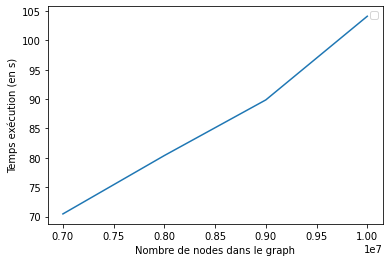

In [ ]:
time_list=[]
nb_node=np.arange(7000000,10000001,1000000)
for i in nb_node:
  print(i)
  time_list.append(optimize_club_V2(i, 34, 30)[2])

plt.plot(nb_node,time_list)
plt.xlabel('Nombre de nodes dans le graph')
plt.ylabel('Temps exécution (en s)')
plt.legend()
plt.show()


In [ ]:
print(time_list)

[70.44502399999692, 80.38748100000157, 89.86044199999742, 104.10515999999916]


In [ ]:
time_list=[]
nb_node=np.arange(10,10000000,100000)
for i in nb_node:
  print(i)
  time_list.append(optimize_club_V2(i, 34, 30)[2])

plt.plot(nb_node,time_list)

In [ ]:
plt.plot(nb_node,time_list)
plt.xlabel('Nombre de nodes dans le graphe')
plt.ylabel('Temps exécution (en s)')
plt.title('Temps exécution avec TPU')
plt.legend()
plt.show()

In [ ]:
Time_List_TPU = [1.1289659999999913, 2.0956490000000088, 3.02034900000001, 3.9236069999999756, 4.824735000000004, 5.7488189999999975, 6.7158509999999865, 7.596469999999982, 8.456999000000025, 9.423506000000003, 10.296402999999998, 11.548473999999999, 11.994245000000035, 12.950504999999964, 13.748486000000014, 14.68483299999997, 15.609442999999999, 16.50408900000002, 17.37025, 18.48096400000003, 19.209235000000035, 20.029488000000015, 20.928160000000048, 21.862989999999968, 22.72283600000003, 23.535068000000024, 24.522469, 25.378798999999958, 27.140242000000057, 27.39387499999998, 28.10399499999994, 28.927179999999908, 29.85936599999991, 31.017705999999862, 31.727343999999903, 32.55393500000014, 33.42752199999995, 34.32053999999994, 35.650847999999996, 36.72946200000001, 38.34154100000001, 38.543296000000055, 39.831597999999985, 40.36091499999998, 41.17726099999982, 43.09846999999991, 43.82834899999989, 44.94521500000019, 45.886581000000206, 46.55362700000023, 47.588836999999785, 48.504683000000114, 49.235044000000016, 49.83933799999977, 51.04462999999987, 51.681579000000056, 52.73153700000012, 53.47852000000012, 54.662091000000146, 55.24377800000002, 56.07388200000014, 57.77805899999976, 57.74851499999977, 58.64904000000024, 59.738794999999755, 60.70954900000015, 61.465963999999985, 62.5208990000001, 63.25935800000025, 63.38538400000016, 65.07208499999979, 65.852578, 67.0742420000006, 67.54332599999998, 68.65754100000049, 69.00406999999996, 69.76891199999955, 71.98243999999977, 71.5385809999998, 72.32072900000003, 73.40027999999984, 74.27769900000021, 75.34929499999998, 76.97899700000016, 77.66413199999988, 78.04701000000023, 79.38281199999983, 79.85655299999962, 80.92981099999997, 81.91936199999964, 82.61209800000051, 82.91204199999993, 84.81136800000058, 86.20688399999926, 85.68375500000002, 86.92872399999942, 87.48077000000012, 89.23282199999994, 90.32157000000007, 91.07315799999924]
Time_list_GPU = [0.6700250000000096, 0.7267149999999987, 0.8058339999999902, 1.0747250000000008, 1.0368310000000065, 1.0412650000000099, 1.1189850000000092, 1.2109049999999968, 1.2987409999999926, 1.3308979999999906, 1.68252600000001, 1.5752760000000023, 1.7030239999999992, 1.8994590000000073, 1.7788140000000112, 1.882932000000011, 2.0982640000000004, 2.0474040000000002, 2.295682999999997, 2.225637000000006, 2.4434080000000336, 2.342415000000017, 2.6504739999999742, 2.5661850000000186, 2.7834530000000086, 2.6395350000000235, 2.9789540000000443, 3.0128710000000183, 2.8685649999999896, 3.220609999999965, 3.2060429999999087, 3.141903999999954, 3.383603999999991, 3.443408999999974, 3.576516999999967, 3.406537999999955, 3.7599350000000413, 3.833686999999941, 3.8616439999999557, 3.890172000000007, 3.9970560000000432, 4.059416999999939, 4.172738999999979, 4.121342000000141, 4.426710999999841, 4.326145999999881, 4.3811900000000605, 4.471379999999954, 4.530305999999882, 4.64124599999991, 4.699716999999964, 4.81307599999991, 4.923052999999982, 4.983461000000034, 5.086868999999979, 5.0912620000001425, 5.199438999999984, 5.236462000000074, 5.3373209999999744, 5.406231000000162, 5.45085099999983, 5.6225610000001325, 5.744583999999804, 5.738706000000093, 5.735552999999982, 5.832419999999729, 6.041070000000218, 6.006464999999935, 6.122670000000198, 6.125162000000273, 6.145246999999927, 6.43822500000033, 6.383057999999892, 6.452328000000307, 6.491490999999769, 6.650148999999601, 6.747581000000082, 6.7571570000000065, 6.868984000000182, 6.919162000000142, 6.973283999999694, 7.021004000000175, 7.147768000000269, 7.268976000000293, 7.319564999999784, 7.351934999999685, 7.523985000000266, 7.667783000000327, 7.625696000000062, 7.767320999999811, 7.936384999999973, 8.049363000000085, 7.954273000000285, 8.114970999999969, 8.052314999999908, 8.14632900000015, 8.139232000000447, 8.334585999999945, 8.330455999999685, 8.411902000000737]

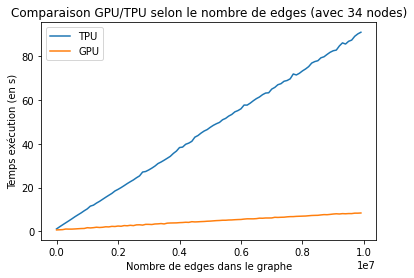

In [ ]:
nb_node=np.arange(10,10000000,100000)
plt.plot(nb_node,Time_List_TPU, label='TPU')
plt.plot(nb_node,Time_list_GPU, label= 'GPU')


plt.xlabel('Nombre de edges dans le graphe')
plt.ylabel('Temps exécution (en s)')
plt.title('Comparaison GPU/TPU selon le nombre de edges (avec 34 nodes)')
plt.legend()
plt.show()

In [ ]:
nb_node=np.arange(10,10000,1000)
for i in nb_node:
  print(i)
  time_list_1.append(optimize_club_V2(100, i, 30)[2])

plt.plot(nb_node,time_list_1)
plt.xlabel('Nombre de nodes dans le graph')
plt.ylabel('Temps exécution (en s)')
plt.legend()
plt.show()


10


NameError: ignored

## Influence du nombre de nodes

1
101
201
301
401
501
601
701
801
901


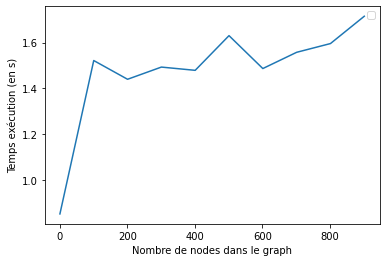

In [ ]:
time_list=[]
nb_node=np.arange(1,1000,100)
for i in nb_node:
  print(i)
  time_list.append(optimize_club_V2(1000, i, 30)[2])

plt.plot(nb_node,time_list)
plt.xlabel('Nombre de nodes dans le graph')
plt.ylabel('Temps exécution (en s)')
plt.legend()
plt.show()

# **Etude de complexité empirique (Allocation mémoire)**

In [ ]:
import seaborn as sns
#Tracemalloc : librairie permettant de déterminer la mémoire utilisée
import tracemalloc

In [ ]:
#Fonction permettant de déterminer la mémoire totale utilisée

def get_memory_usage(snapshot, key_type='lineno', limit=3):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    top_stats = snapshot.statistics(key_type)

    for index, stat in enumerate(top_stats[:limit], 1):
        frame = stat.traceback[0]
    other = top_stats[limit:]
    if other:
        size = sum(stat.size for stat in other)
    total = sum(stat.size for stat in top_stats)
    return total / 1024

In [ ]:
def get_zacharys_karate_club_V2(nb_edge,nb_node) -> jraph.GraphsTuple:
  """Returns GraphsTuple representing Zachary's karate club."""
  social_graph = []
  for i in range(nb_edge):
    a,b=np.random.randint(0,nb_node), np.random.randint(0,nb_node)
    social_graph.append((a,b))

  # Add reverse edges.
  social_graph += [(edge[1], edge[0]) for edge in social_graph]
  n_club_members = nb_node

  return jraph.GraphsTuple(
      n_node=jnp.asarray([n_club_members]),
      n_edge=jnp.asarray([len(social_graph)]),
      # One-hot encoding for nodes.
      #matrice d(1,..,1)
      nodes=jnp.eye(n_club_members),
      # No edge features.
      edges=None,
      globals=None,
      senders=jnp.asarray([edge[0] for edge in social_graph]),
      receivers=jnp.asarray([edge[1] for edge in social_graph]))
  
def get_ground_truth_assignments_for_zacharys_karate_club_V2(nb_node) -> jnp.ndarray:
  """Returns ground truth assignments for Zachary's karate club."""
  temp=list(np.random.randint(0,2,nb_node))
  return jnp.array(temp)


def optimize_club_V2(nb_edge, nb_node, num_steps: int):


  """Solves the karte club problem by optimizing the assignments of students."""
  network = hk.without_apply_rng(hk.transform(network_definition))
  zacharys_karate_club = get_zacharys_karate_club_V2(nb_edge, nb_node)
  labels = get_ground_truth_assignments_for_zacharys_karate_club_V2(nb_node)
  params = network.init(jax.random.PRNGKey(42), zacharys_karate_club)

  tracemalloc.start() 

  @jax.jit
  def prediction_loss(params):
    decoded_nodes = network.apply(params, zacharys_karate_club)
    # We interpret the decoded nodes as a pair of logits for each node.
    log_prob = jax.nn.log_softmax(decoded_nodes)
    # The only two assignments we know a-priori are those of Mr. Hi (Node 0)
    # and John A (Node 33).
    return -(log_prob[0, 0] + log_prob[33, 1])

  opt_init, opt_update = optax.adam(1e-2)
  opt_state = opt_init(params)

  @jax.jit
  def update(params, opt_state):
    g = jax.grad(prediction_loss)(params)
    updates, opt_state = opt_update(g, opt_state)
    return optax.apply_updates(params, updates), opt_state

  @jax.jit
  def accuracy(params):
    decoded_nodes = network.apply(params, zacharys_karate_club)
    return jnp.mean(jnp.argmax(decoded_nodes, axis=1) == labels)

  for step in range(num_steps):
    logging.info("step %r accuracy %r", step, accuracy(params).item())
    params, opt_state = update(params, opt_state)
    #print(accuracy(params))
  
  snapshot = tracemalloc.take_snapshot() 
  memory = get_memory_usage(snapshot)

  return (accuracy(params), prediction_loss(params), memory)

In [ ]:
#Script permettant de calculer la mémoire allouée en fonction du nombre de edges
from tqdm import tqdm
memory_usage =[]
edges = 1000001
nb_node=np.arange(1, edges + 1, 10000)
for i in tqdm(nb_node):
  memory_usage.append(optimize_club_V2(i, 34, 30)[2])

Etant donné que cette partie a été faite sur un notebook différent, pour obtenir le graphe ci-dessous, il suffit de décommenter le code de la cellule suivante. Nous avons enregistré dans des fichiers csv les mémoires trouvées. 

In [ ]:
#gpu = pd.read_csv('gpu.csv')
#cpu = pd.read_csv('cpu.csv')

#plt.plot(gpu['Unnamed: 0'], gpu['Memory'], label='Mémoire GPU')
#plt.plot(cpu['Unnamed: 0'], cpu['Memory'], label='Mémoire CPU')
#plt.xlabel('Nombre de edges')
#plt.ylabel('Mémoire utilisée')
#plt.legend()
#plt.show()

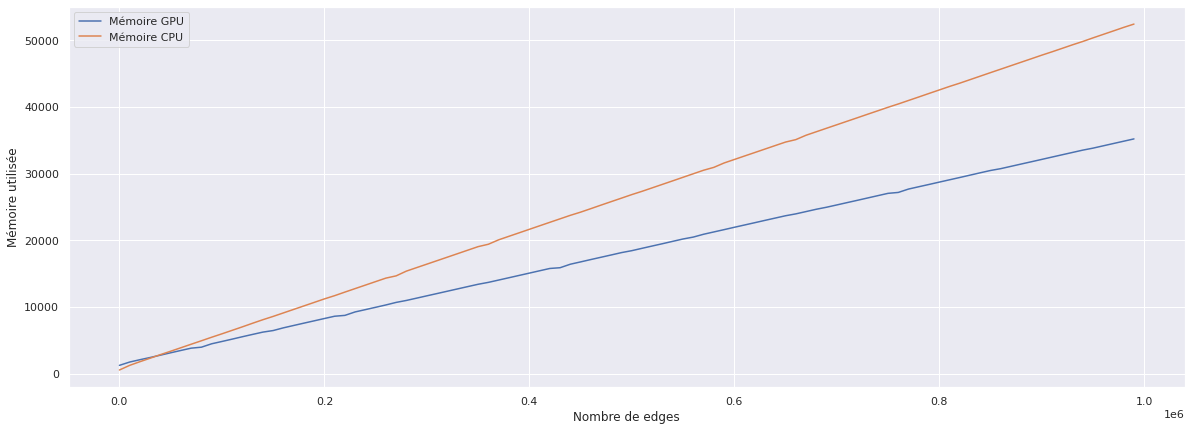

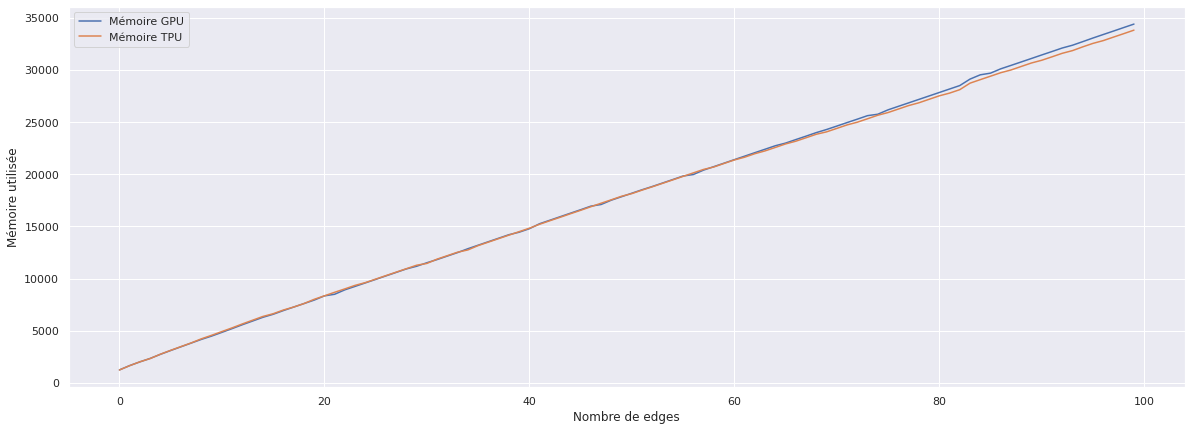

# Exploration des limites, avantages et faiblesses de l’approche avec des jeux de données complémentaires

# 1er jeu de données: email-Eu-core network 

email-Eu-core network (http://snap.stanford.edu/data/email-Eu-core.html)

Description officielle:

"The network was generated using email data from a large European research institution. We have anonymized information about all incoming and outgoing email between members of the research institution. There is an edge (u, v) in the network if person u sent person v at least one email. The e-mails only represent communication between institution members (the core), and the dataset does not contain incoming messages from or outgoing messages to the rest of the world.

The dataset also contains "ground-truth" community memberships of the nodes. Each individual belongs to exactly one of 42 departments at the research institute."

Il y a 1005 nodes et 25571 edges (et donc 42 labels comme indiqué ci-dessus)

### Data Engineering du Dataset 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
fichier_link = open('/content/drive/MyDrive/email-Eu-core.txt', "r")
fichier_label =open('/content/drive/MyDrive/email-Eu-core-department-labels.txt', "r")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
Links = [line.strip() for line in fichier_link] 
print(Links) 

['0 1', '2 3', '2 4', '5 6', '5 7', '8 9', '10 11', '12 13', '12 14', '15 16', '17 18', '12 19', '20 21', '20 22', '23 24', '23 25', '23 26', '23 27', '23 28', '23 29', '23 30', '23 31', '23 32', '23 33', '23 34', '23 35', '23 36', '23 37', '23 38', '23 39', '23 40', '41 42', '43 44', '45 46', '47 48', '49 50', '41 51', '52 53', '54 55', '54 56', '54 57', '54 58', '54 59', '60 61', '54 54', '62 63', '64 65', '62 4', '66 67', '68 69', '42 41', '70 71', '72 21', '71 70', '73 74', '75 76', '75 48', '77 78', '77 79', '80 81', '80 68', '19 62', '82 83', '22 21', '82 84', '21 72', '41 85', '41 86', '41 87', '82 86', '88 89', '90 91', '92 20', '41 93', '41 94', '41 95', '89 96', '89 88', '97 98', '97 99', '97 100', '97 101', '97 102', '103 104', '51 41', '82 105', '90 106', '62 107', '108 109', '108 66', '108 110', '108 111', '108 112', '113 114', '115 116', '117 118', '76 119', '17 120', '82 121', '122 123', '14 12', '124 125', '13 126', '127 128', '127 129', '127 130', '131 132', '40 26', '

In [ ]:
Links_encoded=[]

for i in range(len(Links)):
  Links_encoded.append((int(Links[i].split()[0]),int(Links[i].split()[1])))

print(len(Links_encoded))

25571


In [ ]:
Labels = [line.strip() for line in fichier_label] 
print(Labels) 

['0 1', '1 1', '2 21', '3 21', '4 21', '5 25', '6 25', '7 14', '8 14', '9 14', '10 9', '11 14', '12 14', '13 26', '14 4', '15 17', '16 34', '17 1', '18 1', '19 14', '20 9', '21 9', '22 9', '23 11', '24 11', '25 11', '26 11', '27 11', '28 11', '29 11', '30 11', '31 11', '32 11', '33 11', '34 11', '35 11', '36 11', '37 11', '38 11', '39 11', '40 11', '41 5', '42 34', '43 14', '44 14', '45 17', '46 17', '47 10', '48 10', '49 36', '50 37', '51 5', '52 7', '53 4', '54 22', '55 22', '56 21', '57 21', '58 21', '59 21', '60 7', '61 7', '62 36', '63 21', '64 25', '65 4', '66 8', '67 15', '68 15', '69 15', '70 37', '71 37', '72 9', '73 1', '74 1', '75 10', '76 10', '77 3', '78 3', '79 3', '80 29', '81 15', '82 36', '83 36', '84 37', '85 1', '86 36', '87 34', '88 20', '89 20', '90 8', '91 15', '92 9', '93 4', '94 5', '95 4', '96 20', '97 16', '98 16', '99 16', '100 16', '101 16', '102 38', '103 7', '104 7', '105 34', '106 38', '107 36', '108 8', '109 27', '110 8', '111 8', '112 8', '113 10', '114

In [ ]:
Nodes_and_Labels_encoded=[]

for i in range(len(Labels)):
  Nodes_and_Labels_encoded.append((int(Labels[i].split()[0]),int(Labels[i].split()[1])))

print(Nodes_and_Labels_encoded)

[(0, 1), (1, 1), (2, 21), (3, 21), (4, 21), (5, 25), (6, 25), (7, 14), (8, 14), (9, 14), (10, 9), (11, 14), (12, 14), (13, 26), (14, 4), (15, 17), (16, 34), (17, 1), (18, 1), (19, 14), (20, 9), (21, 9), (22, 9), (23, 11), (24, 11), (25, 11), (26, 11), (27, 11), (28, 11), (29, 11), (30, 11), (31, 11), (32, 11), (33, 11), (34, 11), (35, 11), (36, 11), (37, 11), (38, 11), (39, 11), (40, 11), (41, 5), (42, 34), (43, 14), (44, 14), (45, 17), (46, 17), (47, 10), (48, 10), (49, 36), (50, 37), (51, 5), (52, 7), (53, 4), (54, 22), (55, 22), (56, 21), (57, 21), (58, 21), (59, 21), (60, 7), (61, 7), (62, 36), (63, 21), (64, 25), (65, 4), (66, 8), (67, 15), (68, 15), (69, 15), (70, 37), (71, 37), (72, 9), (73, 1), (74, 1), (75, 10), (76, 10), (77, 3), (78, 3), (79, 3), (80, 29), (81, 15), (82, 36), (83, 36), (84, 37), (85, 1), (86, 36), (87, 34), (88, 20), (89, 20), (90, 8), (91, 15), (92, 9), (93, 4), (94, 5), (95, 4), (96, 20), (97, 16), (98, 16), (99, 16), (100, 16), (101, 16), (102, 38), (103,

In [ ]:
print(len(Nodes_and_Labels_encoded))

1005


In [ ]:
Labels_encoded=[]

for i in range(len(Labels)):
  Labels_encoded.append(int(Labels[i].split()[1]))

print(Labels_encoded)

[1, 1, 21, 21, 21, 25, 25, 14, 14, 14, 9, 14, 14, 26, 4, 17, 34, 1, 1, 14, 9, 9, 9, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 5, 34, 14, 14, 17, 17, 10, 10, 36, 37, 5, 7, 4, 22, 22, 21, 21, 21, 21, 7, 7, 36, 21, 25, 4, 8, 15, 15, 15, 37, 37, 9, 1, 1, 10, 10, 3, 3, 3, 29, 15, 36, 36, 37, 1, 36, 34, 20, 20, 8, 15, 9, 4, 5, 4, 20, 16, 16, 16, 16, 16, 38, 7, 7, 34, 38, 36, 8, 27, 8, 8, 8, 10, 10, 13, 13, 6, 26, 10, 1, 36, 0, 13, 16, 16, 22, 6, 5, 4, 0, 28, 28, 4, 2, 13, 13, 21, 21, 17, 17, 14, 36, 8, 40, 35, 15, 23, 0, 0, 7, 10, 37, 27, 35, 35, 0, 0, 19, 19, 36, 14, 37, 24, 17, 13, 36, 4, 4, 13, 13, 10, 4, 38, 32, 32, 4, 1, 0, 0, 0, 7, 7, 4, 15, 16, 40, 15, 15, 15, 15, 0, 21, 21, 21, 21, 5, 4, 4, 4, 4, 4, 4, 4, 5, 5, 4, 4, 22, 19, 19, 22, 34, 14, 0, 1, 17, 37, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10, 23, 0, 4, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 10, 14, 14, 1, 14, 7, 13, 20, 31, 40, 6, 4, 0, 8, 9, 9, 10, 0, 10, 14, 14, 14, 14, 39, 17, 4, 28, 17, 17, 17

### On réutilise le code fourni en l'adaptant à notre nouveau jeu de donnée





Se pose la question de ce que l'on cosidère comme labels connu à priori pour estimer la loss.

In [ ]:
def get_EU_network() -> jraph.GraphsTuple:
  """Returns GraphsTuple representing Zachary's karate club."""
  social_graph = Links_encoded
  # Add reverse edges.
  social_graph += [(edge[1], edge[0]) for edge in social_graph]
  #25571 edges au total
  n_club_members = 1005

  return jraph.GraphsTuple(
      n_node=jnp.asarray([n_club_members]),
      n_edge=jnp.asarray([len(social_graph)]),
      # One-hot encoding for nodes.
      #matrice d(1,..,1)
      nodes=jnp.eye(n_club_members),
      # No edge features.
      edges=None,
      globals=None,
      senders=jnp.asarray([edge[0] for edge in social_graph]),
      receivers=jnp.asarray([edge[1] for edge in social_graph]))

In [ ]:
def get_ground_truth_assignments_for_EU_network() -> jnp.ndarray:
  """Returns ground truth assignments for our new dataset"""
  return jnp.array(Labels_encoded)

Pour que les études soient comparables, il faut que la taille des réseaux soient proportionnelles: dans le cas du Zachary Karate Club, pour 34 nodes le réseau par défaut était défini avec 5 neurones sur la couche cachée, si on utilise ce même rapport dans ce nouveau cas, il faut en utiliser environ 140.

In [ ]:
def network_definition(graph: jraph.GraphsTuple) -> jraph.ArrayTree:
  """Defines a graph neural network.
  Args:
    graph: GraphsTuple the network processes.
  Returns:
    processed nodes.
  """
  gn = jraph.GraphConvolution(
      update_node_fn=lambda n: jax.nn.relu(hk.Linear(1600)(n)),
      add_self_edges=True)
  graph = gn(graph)

  gn = jraph.GraphConvolution(
      update_node_fn=hk.Linear(42))
  graph = gn(graph)
  return graph.nodes




def optimize(num_steps: int):
  """Solves the EU_network problem by optimizing the assignments of researchers."""
  Accuracy=[]
  network = hk.without_apply_rng(hk.transform(network_definition))
  print(network)
  EU_network = get_EU_network()
  labels = get_ground_truth_assignments_for_EU_network()
  params = network.init(jax.random.PRNGKey(42), EU_network)

  @jax.jit
  def prediction_loss(params):
    decoded_nodes = network.apply(params, EU_network)
    #print(decoded_nodes)
    # We interpret the decoded nodes as a pair of logits for each node.
    log_prob = jax.nn.log_softmax(decoded_nodes)
    # The only two assignments we know a-priori are those of Mr. Hi (Node 0)
    # and John A (Node 33).


    ####################### Le noeud du pb est ici ##################################
    S=0
    for i in range(1005):
      S=S+log_prob[Nodes_and_Labels_encoded[i][0], Nodes_and_Labels_encoded[i][1]]
    
   
    return (-S)
    ####################################################################################

  opt_init, opt_update = optax.adam(1e-2)
  opt_state = opt_init(params)

  @jax.jit
  def update(params, opt_state):
    g = jax.grad(prediction_loss)(params)
    updates, opt_state = opt_update(g, opt_state)
    return optax.apply_updates(params, updates), opt_state

  @jax.jit
  def accuracy(params):
    decoded_nodes = network.apply(params, EU_network)
    return jnp.mean(jnp.argmax(decoded_nodes, axis=1) == labels)

  for step in range(num_steps):
    logging.info("step %r accuracy %r", step, accuracy(params).item())
    params, opt_state = update(params, opt_state)
    Accuracy.append(accuracy(params))
    print(accuracy(params))

  return (accuracy(params), prediction_loss(params),Accuracy)

In [ ]:
Accuracy=optimize(100)[2]

Transformed(init=<function without_state.<locals>.init_fn at 0x7fb5503b49d8>, apply=<function without_apply_rng.<locals>.apply_fn at 0x7fb550475d08>)
0.36119404
0.36019903
0.30845773
0.24079603
0.23880598
0.2915423
0.39402986
0.5044776
0.5900498
0.6258707
0.63681597
0.639801
0.6467662
0.6517413
0.66567165
0.69651747
0.71243787
0.7383085
0.74129355
0.7422886
0.7512438
0.76119405
0.76716423
0.77313435
0.78308463
0.79502493
0.79801
0.80298513
0.8099503
0.81293535
0.8119403
0.82089555
0.8218906
0.8238806
0.8358209
0.83880603
0.84278613
0.8557214
0.8537314
0.86268663
0.8676617
0.8636816
0.8736319
0.8716418
0.8756219
0.87860703
0.88258713
0.8955224
0.8955224
0.8995025
0.90447766
0.9064677
0.9074627
0.9104478
0.9114428
0.9094528
0.919403
0.91641796
0.919403
0.9253732
0.9233831
0.9333334
0.93233836
0.92835826
0.93233836
0.9343284
0.93233836
0.9383085
0.94029856
0.9393035
0.9422886
0.9462687
0.94825876
0.9492538
0.9502488
0.9492538
0.9512438
0.9542289
0.9542289
0.9542289
0.957214
0.9611941
0.96

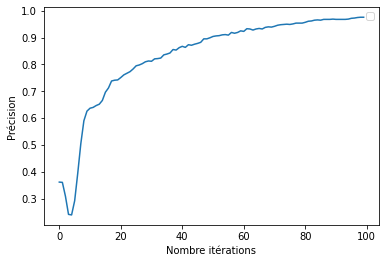

In [ ]:
plt.plot(Accuracy)
plt.xlabel('Nombre itérations')
plt.ylabel('Précision')
plt.legend()
plt.show()

On constate que cette approche est performante à une condition que l'on rappelle: mettre à l'échelle le réseau. Par ailleurs, on constate que pour atteindre une précision de plus de 90%, il faut davantage d'itérations de l'algorithme d'optimisation. Expliquer !!

# 2ème jeu de données: Youtube social Network

Description officielle: "Youtube is a video-sharing web site that includes a social network. In the Youtube social network, users form friendship each other and users can create groups which other users can join. We consider such user-defined groups as ground-truth communities. This data is provided by Alan Mislove et al.

We regard each connected component in a group as a separate ground-truth community. We remove the ground-truth communities which have less than 3 nodes. We also provide the top 5,000 communities with highest quality which are described in our paper. As for the network, we provide the largest connected component."

On a ici 1134890 nodes, 2987624 edges.

### Data engineering du dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
fichier_link_2 = open('/content/drive/MyDrive/com-youtube.ungraph.txt', "r")
fichier_label_2 =open('/content/drive/MyDrive/com-youtube.all.cmty.txt', "r")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
Links_2 = [line.split() for line in fichier_link_2] 
del Links_2[0:4]

print(Links_2[0:1000])

[['1', '2'], ['1', '3'], ['1', '4'], ['1', '5'], ['1', '6'], ['1', '7'], ['1', '8'], ['1', '9'], ['1', '10'], ['1', '11'], ['1', '12'], ['1', '13'], ['1', '14'], ['1', '15'], ['1', '16'], ['1', '17'], ['1', '18'], ['1', '19'], ['1', '20'], ['1', '21'], ['1', '22'], ['1', '376'], ['1', '1219'], ['1', '268635'], ['1', '317880'], ['1', '665255'], ['1', '665256'], ['1', '665257'], ['1', '665258'], ['2', '4'], ['2', '40'], ['2', '106'], ['2', '107'], ['2', '126'], ['2', '134'], ['2', '242'], ['2', '247'], ['2', '276'], ['2', '291'], ['2', '341'], ['2', '363'], ['2', '365'], ['2', '367'], ['2', '404'], ['2', '446'], ['2', '455'], ['2', '480'], ['2', '495'], ['2', '514'], ['2', '534'], ['2', '688'], ['2', '718'], ['2', '723'], ['2', '730'], ['2', '762'], ['2', '776'], ['2', '797'], ['2', '803'], ['2', '839'], ['2', '840'], ['2', '847'], ['2', '848'], ['2', '851'], ['2', '881'], ['2', '882'], ['2', '903'], ['2', '940'], ['2', '967'], ['2', '1009'], ['2', '1013'], ['2', '1070'], ['2', '1085'], 

In [ ]:
Links_encoded_2=[]

for i in range(len(Links_2)):
  Links_encoded_2.append((int(Links_2[i][0]),int(Links_2[i][1])))

print(len(Links_encoded_2))

2987624


In [ ]:
Labels_2 = [line.split() for line in fichier_label_2] 
print(Labels_2[0:100]) 

[['72', '165', '517', '875', '1024', '1742', '2059', '2252', '2429', '3622', '5036', '5080', '5088', '5703', '5873', '6723', '6752', '8459', '8752', '8885', '9553', '10243', '10763', '13040', '13841', '15059', '15231', '15310', '16100', '19170', '19573', '20572', '26797', '27414', '28080', '28084', '28755', '40404', '43824', '48404', '48423', '48431', '61005', '83295', '103527', '108236', '139888', '156355', '156534', '175210', '180201', '181647', '181664', '181665', '183004', '203349', '224411', '279007', '282577', '287218', '319813', '458127', '526519', '645203'], ['1', '3', '5', '539', '551', '554', '571', '626', '642', '673', '678', '684', '698', '700', '9314', '24047', '33897', '36675', '521325'], ['519665', '608725'], ['282492', '406981'], ['234132', '234134'], ['157240', '459129'], ['114418', '114459'], ['58180', '335490'], ['28200', '282586'], ['27182', '106235'], ['25803', '90518'], ['24051', '37101'], ['19715', '51027'], ['11645', '27093'], ['10191', '10992'], ['4221', '12886

In [ ]:
print(len(Labels_2[1]))

19


In [ ]:
Labels_encoded_2=[[] for i in range(1134891)]


for i in range(len(Labels_2)):
  for j in range(len(Labels_2[i])):
    Labels_encoded_2[int(Labels_2[i][j])].append(i)

print(Labels_encoded_2[0:100])

[[], [1, 16], [22, 24], [1], [], [1, 16, 34, 35, 36, 37, 38, 42, 46, 47, 48, 51, 52, 53], [], [], [], [], [], [80, 84], [], [85, 108], [117], [85, 108, 119, 135, 140, 150, 164, 175, 205, 213, 215, 227, 232, 245, 248, 251, 255, 259, 260, 263], [], [], [266], [], [], [], [], [], [], [], [428, 429], [], [430, 431, 432, 433], [], [], [], [], [434, 436, 439, 441, 442, 443, 444], [445, 446, 448, 451, 455, 459, 461, 464, 468, 472, 474, 478, 479, 481], [], [], [], [], [], [54, 85, 108, 119, 215, 232, 245, 267, 482, 484, 514, 519, 524, 530, 536, 539, 544, 545, 548, 550, 551], [482], [], [554, 557, 579, 586, 587, 592], [593, 594], [], [], [267], [], [430, 432], [], [], [85, 514, 596, 607, 610, 614, 628, 629, 635], [], [], [], [636], [], [638, 639], [645, 657, 661], [666, 669], [670, 671], [], [672, 674, 675, 676, 677, 678], [681, 684], [], [], [], [119], [], [], [], [0, 80, 135, 140, 150, 164, 175, 267, 482, 484, 700, 719, 731, 752, 764, 777, 787, 793, 802, 815, 821, 827, 833, 839, 853, 862, 905

In [ ]:
Labels_encoded_2_bis=[0 for i in range(1134891)]


for i in range(len(Labels_2)):
  for j in range(len(Labels_2[i])):
    Labels_encoded_2_bis[int(Labels_2[i][j])]=(i)

print(Labels_encoded_2_bis[0:100])

[0, 16, 24, 1, 0, 53, 0, 0, 0, 0, 0, 84, 0, 108, 117, 263, 0, 0, 266, 0, 0, 0, 0, 0, 0, 0, 429, 0, 433, 0, 0, 0, 0, 444, 481, 0, 0, 0, 0, 0, 551, 482, 0, 592, 594, 0, 0, 267, 0, 432, 0, 0, 635, 0, 0, 0, 636, 0, 639, 661, 669, 671, 0, 678, 684, 0, 0, 0, 119, 0, 0, 0, 1010, 1015, 267, 0, 0, 0, 1023, 0, 0, 0, 0, 1028, 0, 0, 0, 0, 0, 0, 1032, 85, 0, 0, 1037, 731, 0, 1043, 0, 0]


In [ ]:
print(max(Labels_encoded_2_bis))

16385


In [ ]:
print(Labels_encoded_2[72])

[0, 80, 135, 140, 150, 164, 175, 267, 482, 484, 700, 719, 731, 752, 764, 777, 787, 793, 802, 815, 821, 827, 833, 839, 853, 862, 905, 915, 943, 974, 975, 976, 986, 988, 992, 993, 1002, 1003, 1009, 1010]


On voit apparaître une première limite de l'approche puisqu'elle n'est pas adaptée au cas où des individus appartiennent à plusieurs communautés. 

### On réutilise le code fourni en l'adaptant à notre nouveau jeu de donnée

In [ ]:
def get_youtube_social_newtwork() -> jraph.GraphsTuple:
  """Returns GraphsTuple representing Zachary's karate club."""
  social_graph = Links_encoded_2
  print('init social graph: Ok')
  # Add reverse edges.
  social_graph += [(edge[1], edge[0]) for edge in social_graph]
  print('Making social graph undirected: Ok')
  #156 edges au total
  n_club_members = 1134890 

  return jraph.GraphsTuple(
      n_node=jnp.asarray([n_club_members]),
      n_edge=jnp.asarray([len(social_graph)]),
      # One-hot encoding for nodes.
      #matrice d(1,..,1)
      nodes=jnp.eye(n_club_members),
      # No edge features.
      edges=None,
      globals=None,
      senders=jnp.asarray([edge[0] for edge in social_graph]),
      receivers=jnp.asarray([edge[1] for edge in social_graph]))

def get_ground_truth_assignments_for_youtube_network() -> jnp.ndarray:
  """Returns ground truth assignments for our new dataset"""
  return jnp.array(Labels_encoded_2_bis)


def network_definition(graph: jraph.GraphsTuple) -> jraph.ArrayTree:
  """Defines a graph neural network.
  Args:
    graph: GraphsTuple the network processes.
  Returns:
    processed nodes.
  """
  gn = jraph.GraphConvolution(
      update_node_fn=lambda n: jax.nn.relu(hk.Linear(5)(n)),
      add_self_edges=True)
  graph = gn(graph)

  gn = jraph.GraphConvolution(
      update_node_fn=hk.Linear(40))
  graph = gn(graph)
  return graph.nodes


def optimize_club(num_steps: int):
  """Solves the karte club problem by optimizing the assignments of students."""
  network = hk.without_apply_rng(hk.transform(network_definition))
  print('init network: Ok')
  youtube_social_newtwork = get_youtube_social_newtwork()
  print('get_youtube_social_network: Ok')
  labels = get_ground_truth_assignments_for_youtube_network()
  print('get label: Ok')
  params = network.init(jax.random.PRNGKey(42), zacharys_karate_club)
  print('init paramnetwork : ok')

  @jax.jit
  def prediction_loss(params):
    decoded_nodes = network.apply(params, youtube_social_newtwork)
    # We interpret the decoded nodes as a pair of logits for each node.
    log_prob = jax.nn.log_softmax(decoded_nodes)
    # The only two assignments we know a-priori are those of Mr. Hi (Node 0)
    # and John A (Node 33).
    return -(log_prob[0, 0] + log_prob[33, 1])

  opt_init, opt_update = optax.adam(1e-2)
  opt_state = opt_init(params)

  @jax.jit
  def update(params, opt_state):
    g = jax.grad(prediction_loss)(params)
    updates, opt_state = opt_update(g, opt_state)
    return optax.apply_updates(params, updates), opt_state

  @jax.jit
  def accuracy(params):
    decoded_nodes = network.apply(params, youtube_social_newtwork)
    return jnp.mean(jnp.argmax(decoded_nodes, axis=1) == labels)

  for step in range(num_steps):
    print('step: ', step)
    logging.info("step %r accuracy %r", step, accuracy(params).item())
    print('logging', step)
    params, opt_state = update(params, opt_state)
    print('udpate param step :',i)
    print(accuracy(params))

  return (accuracy(params), prediction_loss(params))



In [ ]:
optimize_club(10)

init network: Ok
init social graph: Ok


Making social graph undirected: Ok


# Robustesse de l'approche

On définit la robustesse de l'approche vis à vis d'attaque comme étant l'influence du bruitage des connexsions sur la précision. Par bruitage des connexion, on entend l'ajout ou le retrait de connexions. 

Pour cette question nous allons donc revenir au cas du zachary karaté club et voir l'influence de l'ajout et du retrait de edges sur la précision du modèle.

In [ ]:
from random import randrange

In [ ]:
def get_partial_zacharys_karate_club(Ajout,Retrait,N) -> jraph.GraphsTuple:
  """On retourne un GraphsTuple représentant le Zachary's karate club en ayant enlevé ou ajouté des edges selon les arguments. Ajout et retrait doivent être des booléens.
  N indique le nombre de edge que l'on enlève ou que l'on ajoute"""

  social_graph = [
      (1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
      (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
      (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
      (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
      (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
      (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
      (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
      (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
      (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
      (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
      (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
      (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
      (33, 31), (33, 32)]

  if Ajout:
    for i in range(N):
      a=randrange(len(social_graph))
      b=randrange(len(social_graph))
      social_graph.append((a,b))

  if Retrait:
    if N>len(social_graph):
      return ('Erreur: On ne peut enlever plus de edges qu il n en existe originellement dans le graphe')
    else:
      for i in range(N):
        del social_graph[randrange(len(social_graph))]
        

  ######## 
  # Add reverse edges.
  social_graph += [(edge[1], edge[0]) for edge in social_graph]
  #156 edges au total
  n_club_members = 34

  return jraph.GraphsTuple(
      n_node=jnp.asarray([n_club_members]),
      n_edge=jnp.asarray([len(social_graph)]),
      # One-hot encoding for nodes.
      #matrice d(1,..,1)
      nodes=jnp.eye(n_club_members),
      # No edge features.
      edges=None,
      globals=None,
      senders=jnp.asarray([edge[0] for edge in social_graph]),
      receivers=jnp.asarray([edge[1] for edge in social_graph]))

def get_ground_truth_assignments_for_zacharys_karate_club() -> jnp.ndarray:
  """Returns ground truth assignments for Zachary's karate club."""
  return jnp.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
                    0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
  
def network_definition_v3(graph: jraph.GraphsTuple) -> jraph.ArrayTree:
  """Defines a graph neural network.
  Args:
    graph: GraphsTuple the network processes.
  Returns:
    processed nodes.
  """
  gn = jraph.GraphConvolution(
      update_node_fn=lambda n: jax.nn.relu(hk.Linear(5)(n)),
      add_self_edges=True)
  graph = gn(graph)

  gn = jraph.GraphConvolution(
      update_node_fn=hk.Linear(2))
  graph = gn(graph)
  return graph.nodes

def optimize_partial_club(num_steps: int, Ajout: bool, Retrait: bool, N: int):
  """Solves the karate club problem by optimizing the assignments of students"""

  network = hk.without_apply_rng(hk.transform(network_definition_v3))
  zacharys_karate_club = get_partial_zacharys_karate_club(Ajout, Retrait, N)
  labels = get_ground_truth_assignments_for_zacharys_karate_club()
  params = network.init(jax.random.PRNGKey(42), zacharys_karate_club)

  @jax.jit
  def prediction_loss(params):
    decoded_nodes = network.apply(params, zacharys_karate_club)
    # We interpret the decoded nodes as a pair of logits for each node.
    log_prob = jax.nn.log_softmax(decoded_nodes)
    # The only two assignments we know a-priori are those of Mr. Hi (Node 0)
    # and John A (Node 33).
    return -(log_prob[0, 0] + log_prob[33, 1])

  opt_init, opt_update = optax.adam(1e-2)
  opt_state = opt_init(params)

  @jax.jit
  def update(params, opt_state):
    g = jax.grad(prediction_loss)(params)
    updates, opt_state = opt_update(g, opt_state)
    return optax.apply_updates(params, updates), opt_state

  @jax.jit
  def accuracy(params):
    decoded_nodes = network.apply(params, zacharys_karate_club)
    return jnp.mean(jnp.argmax(decoded_nodes, axis=1) == labels)

  for step in range(num_steps):
    logging.info("step %r accuracy %r", step, accuracy(params).item())
    params, opt_state = update(params, opt_state)
    #print(accuracy(params))

  return (accuracy(params), prediction_loss(params))



## Influence de l'ajout de nouvelles connexions 

0.61764705
0.7352941
0.6764706
0.64705884
0.64705884
0.7058824
0.8235294
0.85294116
0.88235295
0.9117647
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.7058824
0.7647059
0.6764706
0.6764706
0.7352941
0.7941176
0.85294116
0.88235295
0.9411765
0.97058827
0.97058827
0.97058827
0.97058827
0.97058827
0.97058827
0.97058827
0.97058827
0.97058827
0.97058827
0.97058827
0.97058827
0.97058827
0.97058827
0.97058827
0.97058827
0.97058827
0.97058827
0.97058827
0.97058827
0.97058827
0.5294118
0.61764705
0.7647059
0.85294116
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.9411765
0.61764705
0.5294118
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5882353
0.70588

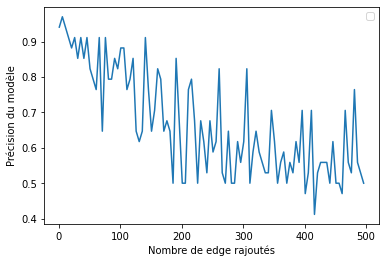

In [ ]:
X=[(5*i)+1 for i in range(100)]
history1=[]
for x in X:
  history.append(optimize_partial_club(30, True, False, x)[0])

plt.plot(X,history1)
plt.xlabel('Nombre de edge rajoutés')
plt.ylabel('Précision du modèle')
plt.legend()
plt.show()

## Influence du retrait de connexions

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77


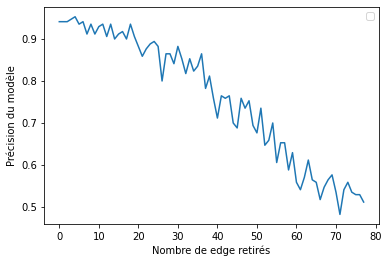

In [ ]:
X=[i for i in range(78)] #78 est le nombre de edge de social_graph
history2=[]
for x in X:
  print(x)
  m=0
  for j in range(5):
    m=m+optimize_partial_club(30, False, True, x)[0]

  history2.append(m/5)


plt.plot(X,history2)
plt.xlabel('Nombre de edge retirés')
plt.ylabel('Précision du modèle')
plt.legend()
plt.show()

Y'a t'il des nodes qui ont plus d'influence que d'autres ? On décide maintenant de ne retirer aucune connexion relié au node 0 et 33 (qui correspondent au professeur Hi et John A).

In [ ]:
def get_partial_zacharys_karate_club(Retrait,N) -> jraph.GraphsTuple:
  """Ici, on retourne un GraphsTuple représentant le Zachary's karate club en ayant enlevé N edges qui ne sont pas liés aux nodes 0 et 33.
  Pour ce faire, on définit le réseau comme deux listes de edges: dans la première il y a tous les edges reliés à 0 ou 33 qu'on ne peut donc pas modifié. Dans l'autre liste on met
  les autres edges et on peut les supprimer"""

  social_graph_0_or_33 = [
      (1, 0), (2, 0), (3, 0),
      (4, 0), (5, 0), (6, 0), (7, 0), (7, 1),
      (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
      (10, 5), (11, 0), (12, 0), (13, 0), (17, 0), (19, 0),
      (21, 0),
      (31, 0), (33, 8), (33, 9), (33, 13),
      (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
      (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
      (33, 31), (33, 32)]

  social_graph_other=[(2, 1), (3, 1), (3, 2), (6, 4), (6, 5), (7, 2), (7, 3), (12, 3), (13, 1), (13, 2),
      (13, 3), (16, 5), (16, 6), (17, 1), (19, 1), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
      (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
      (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
      (32, 29), (32, 30), (32, 31)]

  if Retrait:
    if N>len(social_graph_other):
      return ('Erreur: On ne peut enlever plus de edges que le nombre de edge non relié à 0 ou 33')
    else:
      for i in range(N):
        del social_graph_other[randrange(len(social_graph_other))]
        

  ######## 
  # Add reverse edges.
  social_graph=social_graph_0_or_33 + social_graph_other
  social_graph += [(edge[1], edge[0]) for edge in social_graph]
  #156 edges au total
  n_club_members = 34

  return jraph.GraphsTuple(
      n_node=jnp.asarray([n_club_members]),
      n_edge=jnp.asarray([len(social_graph)]),
      # One-hot encoding for nodes.
      #matrice d(1,..,1)
      nodes=jnp.eye(n_club_members),
      # No edge features.
      edges=None,
      globals=None,
      senders=jnp.asarray([edge[0] for edge in social_graph]),
      receivers=jnp.asarray([edge[1] for edge in social_graph]))

def get_ground_truth_assignments_for_zacharys_karate_club() -> jnp.ndarray:
  """Returns ground truth assignments for Zachary's karate club."""
  return jnp.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
                    0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
  
def network_definition_v3(graph: jraph.GraphsTuple) -> jraph.ArrayTree:
  """Defines a graph neural network.
  Args:
    graph: GraphsTuple the network processes.
  Returns:
    processed nodes.
  """
  gn = jraph.GraphConvolution(
      update_node_fn=lambda n: jax.nn.relu(hk.Linear(5)(n)),
      add_self_edges=True)
  graph = gn(graph)

  gn = jraph.GraphConvolution(
      update_node_fn=hk.Linear(2))
  graph = gn(graph)
  return graph.nodes

def optimize_partial_club(num_steps: int, Retrait: bool, N: int):
  """Solves the karate club problem by optimizing the assignments of students"""

  network = hk.without_apply_rng(hk.transform(network_definition_v3))
  zacharys_karate_club = get_partial_zacharys_karate_club(Retrait, N)
  labels = get_ground_truth_assignments_for_zacharys_karate_club()
  params = network.init(jax.random.PRNGKey(42), zacharys_karate_club)

  @jax.jit
  def prediction_loss(params):
    decoded_nodes = network.apply(params, zacharys_karate_club)
    # We interpret the decoded nodes as a pair of logits for each node.
    log_prob = jax.nn.log_softmax(decoded_nodes)
    # The only two assignments we know a-priori are those of Mr. Hi (Node 0)
    # and John A (Node 33).
    return -(log_prob[0, 0] + log_prob[33, 1])

  opt_init, opt_update = optax.adam(1e-2)
  opt_state = opt_init(params)

  @jax.jit
  def update(params, opt_state):
    g = jax.grad(prediction_loss)(params)
    updates, opt_state = opt_update(g, opt_state)
    return optax.apply_updates(params, updates), opt_state

  @jax.jit
  def accuracy(params):
    decoded_nodes = network.apply(params, zacharys_karate_club)
    return jnp.mean(jnp.argmax(decoded_nodes, axis=1) == labels)

  for step in range(num_steps):
    logging.info("step %r accuracy %r", step, accuracy(params).item())
    params, opt_state = update(params, opt_state)
    #print(accuracy(params))

  return (accuracy(params), prediction_loss(params))

In [ ]:
len([(2, 1), (3, 1), (3, 2), (6, 4), (6, 5), (7, 2), (7, 3), (12, 3), (13, 1), (13, 2),
      (13, 3), (16, 5), (16, 6), (17, 1), (19, 1), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
      (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
      (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
      (32, 29), (32, 30), (32, 31)])

40

On fait le calcul de la précision en faisant la moyenne sur 5 réalisations.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


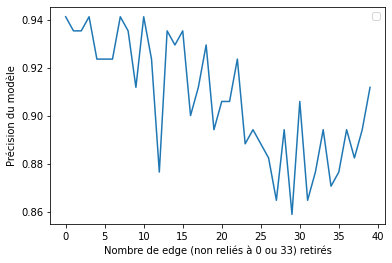

In [ ]:
X=[i for i in range(40)] #40 est le nombre de edge de social_graph_other
history3=[]
for x in X:
  print(x)
  m=0
  for j in range(5):
    m=m+optimize_partial_club(30, True, x)[0]

  history3.append(m/5)

plt.plot(X,history3)
plt.xlabel('Nombre de edge (non reliés à 0 ou 33) retirés')
plt.ylabel('Précision du modèle')
plt.legend()
plt.show()

Pour le même nombre de edge retirés les performances sont meilleures quant on ne touche pas aux edges 0 et 33. Développer

In [ ]:
len( [
      (1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
      (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
      (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
      (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
      (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
      (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
      (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
      (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
      (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
      (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
      (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
      (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
      (33, 31), (33, 32)])

78